# Introduction to Deep Learning with PyTorch Lightning

In another notebook, we saw how PyTorch can be used to train a model. In this notebook, we will go over [PyTorch Lightening]( https://lightning.ai/docs/pytorch/stable/). 


PyTorch Lightning is the deep learning framework with “batteries included” for professional AI researchers and machine learning engineers who need maximal flexibility while super-charging performance at scale.

Lightning organizes PyTorch code to remove boilerplate and unlock scalabily.it While doing so, it still offers full flexibility to try any idea without the boilerplate. It helps you focus on the core parts of your model training and provide you with a standard way to organise yo code.

L
Let us now create a neural network in PyTorch. We will use this network to train a model to take MNIST data as input and produce the class it belongs to.


#### Running in Colab/Kaggle

If you are running this on Colab, please uncomment below cells and run this to install required dependencies.

In [ ]:
# !pip install lightning

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import lightning.pytorch as pl

%matplotlib inline

### MNIST 

MNIST dataset has images 28x28 pixels  = 784 pixels. 

We will have 10 units at the output layer to signify the digit (0-9) the image belongs to.

Let us first load the data and print some images

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(0.5, 0.5),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

In [3]:
# let us load a batch of training data and checkout its shape
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [4]:
images.size()

torch.Size([128, 1, 28, 28])

image size of `(32,1,28,28)` means that we have 32 images, with each image of size (1x28x28) (channels x height x width)

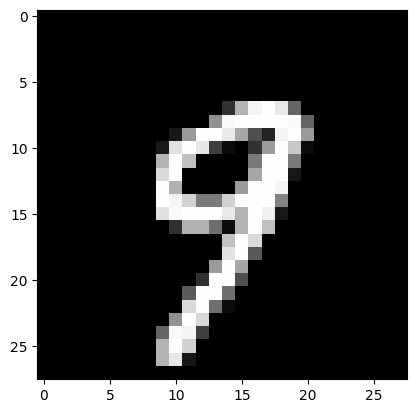

In [5]:
# Let us plot one image
plt.imshow(images[10].numpy().squeeze(), cmap='Greys_r')

### Build Network

In [6]:
model = nn.Sequential(
            nn.Linear(28 * 28, 192), 
            nn.ReLU(), 
            nn.Linear(192, 128),
            nn.ReLU(),
            nn.Linear(128,10)
)

model

Sequential(
  (0): Linear(in_features=784, out_features=192, bias=True)
  (1): ReLU()
  (2): Linear(in_features=192, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
)

### Forward pass and Calculate Cross Entropy Loss

In [7]:
# function to view the probability of classification of digit
def view_classification(img, probs):
    probs = probs.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,7), ncols=2)
    ax1.imshow(img.numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10).astype(int), size='large');
    ax2.set_title('Probability')
    ax2.set_xlim(0, 1.1)
    

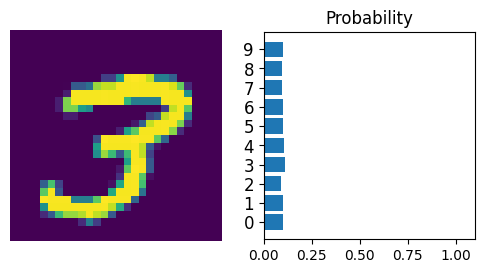

In [8]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
images.resize_(128, 784)

# Forward pass through the network
img_idx = 0
logits = model.forward(images)

# Predict the class from the network output
prediction = F.softmax(logits, dim=1)

img = images[0].data
view_classification(img.reshape(1, 28, 28), prediction[0])

In [9]:
trainloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

#### Define a Lighning Module

In [10]:
# define the LightningModule
class MNISTClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        logits = self.model(x)
        loss = F.cross_entropy(logits,y)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        logits = self.model(x)
        loss = F.cross_entropy(logits, y)
        self.log("test_loss", loss)        

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer


# init the MNIST Classifier
classifier = MNISTClassifier(model)

#### Train the model

In [11]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = pl.Trainer(max_epochs=2)
trainer.fit(model=classifier, train_dataloaders=trainloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-10-16 19:16:29.089081: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-16 19:16:29.714684: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-16 19:16:29.714762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-16 19:16:29.717316: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempt

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


#### Test the model

In [12]:
trainer.test(dataloaders=testloader)

/home/nsanghi/sandbox/apress/drl-2ed/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/nsanghi/sandbox/apress/drl-2ed/chapter5/lightning_logs/version_7/checkpoints/epoch=1-step=938.ckpt
Loaded model weights from the checkpoint at /home/nsanghi/sandbox/apress/drl-2ed/chapter5/lightning_logs/version_7/checkpoints/epoch=1-step=938.ckpt
/home/nsanghi/sandbox/apress/drl-2ed/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling o

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.1643950194120407     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1643950194120407}]

### Predict with Trained Model

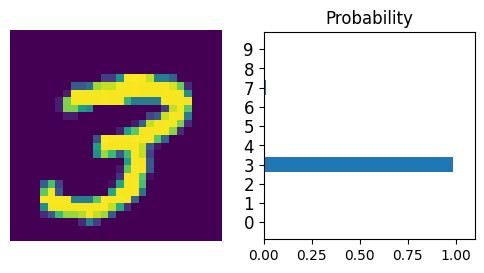

In [13]:
logits = model.forward(img[None,])
model.eval()

# Predict the class from the network output
prediction = F.softmax(logits, dim=1)

view_classification(img.reshape(1, 28, 28), prediction[0])

We can see that model is able to correctly predict the digit after training while before training it predicting all digits with almost equal probability i.e. it was randomly predicting the digit. We also see that PyTorch Lighning reduced the bolierplate code a lot. We just need to define the forward pass and loss calculation for train and test step. And just need to define the initial configuration of the optimizer.

There is no need to define individual training loops and manage the streaming of data through the dataloader. There is no need to code the backward step through the optimizer.

The code you have written in MNSITClassifier is specific to your problem with almost zero boilerplate code.